In [1]:
from IPython.core.display import clear_output
import friendlysam as fs
import pandas as pd
import model_factory
import matplotlib.pyplot as plt
# Optional import for nicer figures
try:
    import seaborn as sns
except ImportError:
    print('Could not import seaborn')
# Optional import for saving/loading with pickle
try:
    import dill
except ImportError:
    print('Could not import dill')
%matplotlib inline

In [2]:
seed = 2
t0 = pd.Timestamp('2013-01-01')
t_end = pd.Timestamp('2013-12-29')
parameters = model_factory.get_parameters(
    time_unit=pd.Timedelta('6h'),
    step=pd.Timedelta('24h'))

m = model_factory.make_model(parameters, seed=seed)
m.time = t0
m.solver = fs.get_solver()
while m.time <= t_end:
    clear_output(wait=True)
    print('Simulating...', m.time)
    m.advance()
print('Done!')

# Save model with dill pickle:
# dill.dump(m, open(filename, 'wb'))

# And open it again like this:
# m = dill.load(open(filename, 'rb'))

Simulating... 2013-12-29 00:00:00
Done!


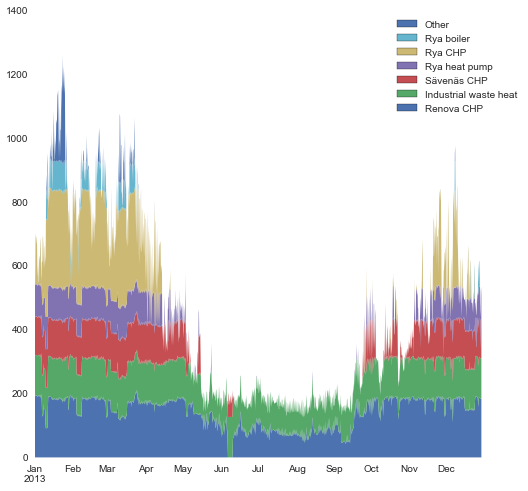

In [3]:
from model_factory import Resources

def is_producer(part, resource):
    return resource in part.production

heat_producers = [p for p in m.descendants
                  if is_producer(p, Resources.heat) and not isinstance(p, fs.Cluster)]

times = m.times_between(t0, t_end)

heat = {p.name: fs.get_series(p.production[Resources.heat], times) for p in heat_producers}
heat = pd.DataFrame.from_dict(heat)
other = [
'Sävenäs boiler A',
'Sävenäs boiler B',
'Högsbo CHP',
'Rosenlund boiler B',
'Rosenlund boiler A',
'Angered boiler',
'Tynnered boiler',
]
heat['Other'] = heat[other].sum(axis=1)
for key in other:
    del heat[key]

order = ['Renova CHP',
'Industrial waste heat',
'Sävenäs CHP',
'Rya heat pump',
'Rya CHP',
'Rya boiler',
'Other'
]
heat = heat[order]

heat *= pd.Timedelta('1h') / heat.index.freq

p = heat.plot(kind='area', legend='reverse', lw=0, figsize=(8,8))
p.get_legend().set_bbox_to_anchor((1.1, 1))

In [4]:
print(heat.sum())

Renova CHP               204011.443167
Industrial waste heat    164200.775847
Sävenäs CHP               93488.839848
Rya heat pump             61481.494868
Rya CHP                  110120.793801
Rya boiler                14071.859890
Other                      9561.574981
dtype: float64
